<a href="https://colab.research.google.com/github/clionelove123/temp_test/blob/main/Chap_11_GAN_modified.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
import tensorflow as tf

In [26]:
# GIF를 만들기위해 설치합니다.
!pip install imageio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [27]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

!mkdir '/content/generated_output/'

mkdir: cannot create directory ‘/content/generated_output/’: File exists


In [28]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

In [29]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5 # 이미지를 [-1, 1]로 정규화합니다.

In [30]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [31]:
# 데이터 배치를 만들고 섞습니다.
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [32]:
# 생성자
# 생성자는 시드값(임의의 노이즈)에서 이미지를 생성하기 위해, tf.keras.layers.Conv2DTranspose(업샘플링) 레이어를 이용합니다. 처음 Dense 레이어는 해당 시드값을 입력값으로 받습니다. 다음으로 원하는 크기인 28x28x1의 이미지에 도달할 때까지 업샘플링을 여러 번 수행합니다. tanh 함수를 사용하는 출력 레이어를 제외한 각 레이어에서 tf.keras.layers.LeakyReLU 활성화가 사용됩니다.

def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256) # 주목: 배치사이즈로 None이 주어집니다.

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

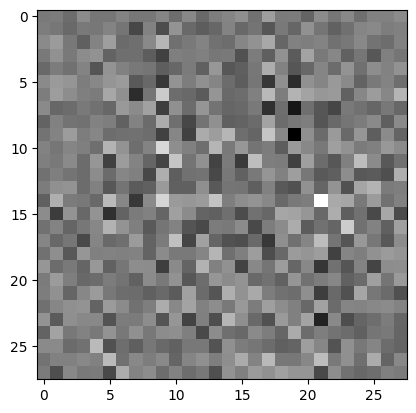

In [33]:
# (아직 훈련이 되지않은) 생성자를 이용해 이미지를 생성해봅시다.
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [34]:
# 감별자
# 감별자는 합성곱 신경망(Convolutional Neural Network, CNN) 기반의 이미지 분류기입니다.

def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [35]:
# (아직까지 훈련이 되지 않은) 감별자를 사용하여, 생성된 이미지가 진짜인지 가짜인지 판별합니다. 
# 모델은 진짜 이미지에는 양수의 값 (positive values)을, 가짜 이미지에는 음수의 값 (negative values)을 출력하도록 훈련되어집니다.

discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[-0.00202969]], shape=(1, 1), dtype=float32)


In [36]:
# 이 메서드는 크로스 엔트로피 손실함수 (cross entropy loss)를 계산하기 위해 헬퍼 (helper) 함수를 반환합니다.
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [37]:
# 감별자 손실함수
# 이 메서드는 감별자가 가짜 이미지에서 얼마나 진짜 이미지를 잘 판별하는지 수치화합니다. 
# 진짜 이미지에 대한 감별자의 예측과 1로 이루어진 행렬을 비교하고, 가짜 (생성된) 이미지에 대한 감별자의 예측과 0으로 이루어진 행렬을 비교합니다.
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss


In [38]:
# 생성자 손실함수
# 생성자의 손실은 판별자를 얼마나 잘 속일 수 있었는지를 수치화합니다. 
# 직관적으로, 생성자가 잘 작동하면 판별자는 가짜 이미지를 실제(또는 1)로 분류합니다. 여기에서 생성된 이미지에 대한 판별자의 판단을 1의 배열과 비교합니다.

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)


In [39]:
# 판별자와 생성자 옵티마이저는 두 네트워크를 별도로 훈련하기 때문에 서로 다릅니다.
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [40]:
# 체크포인트 저장
# 이 노트북은 오랫동안 진행되는 훈련이 중단된 경우 유용한 모델의 저장 및 복구 방법을 보여줍니다.

checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [41]:
EPOCHS = 150
noise_dim = 100
num_examples_to_generate = 16

# 이 시드를 시간이 지나도 재활용하겠습니다. 
# (GIF 애니메이션에서 진전 내용을 시각화하는데 쉽기 때문입니다.) 

seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [42]:
# 생성자가 입력으로 임의의 시드를 받으면 훈련 루프가 시작됩니다. 
# 해당 시드는 이미지를 생성하는 데 사용됩니다. 감별자를 사용하여 (훈련 세트에서 가져온) 진짜 이미지와 (생성자를 통해 생성된) 가짜 이미지를 분류합니다. 
# 각 모델의 손실을 계산하고, 그래디언트를 사용해 생성자와 감별자를 업데이트합니다.

# `tf.function`이 어떻게 사용되는지 주목해 주세요.
# 이 데코레이터는 함수를 "컴파일"합니다.
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [43]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # GIF를 위한 이미지를 바로 생성합니다.
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # 15 에포크가 지날 때마다 모델을 저장합니다.
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)
    
    # print (' 에포크 {} 에서 걸린 시간은 {} 초 입니다'.format(epoch +1, time.time()-start))
    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # 마지막 에포크가 끝난 후 생성합니다.
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

In [44]:
def generate_and_save_images(model, epoch, test_input):
  # `training`이 False로 맞춰진 것을 주목하세요.
  # 이렇게 하면 (배치정규화를 포함하여) 모든 층들이 추론 모드로 실행됩니다. 
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('/content/generated_output/image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

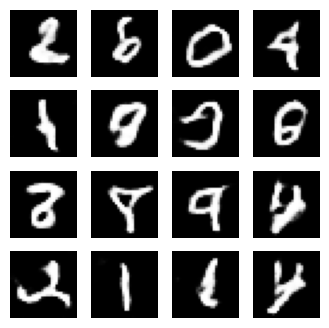

In [45]:
# 모델 훈련
# 위에서 정의한 train() 메서드를 호출하여 생성자와 판별자를 동시에 훈련합니다. 
# GAN 훈련은 까다로울 수 있습니다. 생성자와 판별자가 서로를 압도하지 않는 것이 중요합니다(예: 비슷한 속도로 훈련됨).
# 훈련 초기에 생성된 이미지는 무작위 노이즈처럼 보입니다. 훈련이 진행됨에 따라 생성된 숫자는 점점 더 실제처럼 보일 것입니다. 

train(train_dataset, EPOCHS)

In [46]:
# 마지막 체크포인트를 복구합니다.

checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))


In [49]:
# 에포크 숫자를 사용하여 하나의 이미지를 보여줍니다.

def display_image(epoch_no):
  return PIL.Image.open('/content/generated_output/image_at_epoch_{:04d}.png'.format(epoch_no))

In [51]:
anim_file = '/content/generated_output/dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('/content/generated_output/image*.png')
  filenames = sorted(filenames)
  last = -1
  for i,filename in enumerate(filenames):
    frame = 2*(i**0.5)
    if round(frame) > round(last):
      last = frame
    else:
      continue
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

import IPython
if IPython.version_info > (6,2,0,''):
  display.Image(filename=anim_file)

<ipython-input-51-b2b7cd20ce6a>:13: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
<ipython-input-51-b2b7cd20ce6a>:15: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


In [53]:
!zip -r /content/file.zip /content/generated_output

from google.colab import files
files.download("/content/file.zip")

updating: content/generated_output/ (stored 0%)
updating: content/generated_output/image_at_epoch_0062.png (deflated 10%)
updating: content/generated_output/image_at_epoch_0064.png (deflated 9%)
updating: content/generated_output/image_at_epoch_0147.png (deflated 9%)
updating: content/generated_output/image_at_epoch_0107.png (deflated 9%)
updating: content/generated_output/image_at_epoch_0046.png (deflated 9%)
updating: content/generated_output/image_at_epoch_0035.png (deflated 9%)
updating: content/generated_output/image_at_epoch_0106.png (deflated 9%)
updating: content/generated_output/image_at_epoch_0006.png (deflated 7%)
updating: content/generated_output/image_at_epoch_0115.png (deflated 9%)
updating: content/generated_output/image_at_epoch_0073.png (deflated 9%)
updating: content/generated_output/image_at_epoch_0103.png (deflated 9%)
updating: content/generated_output/image_at_epoch_0105.png (deflated 9%)
updating: content/generated_output/image_at_epoch_0040.png (deflated 9%)
up

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>